In [17]:
import pandas as pd
import os
from constants import train_path
import requests
from bioc import biocxml, pubtator

#load annotated data
dat_df = pd.read_csv(os.path.join(train_path, "annotations.tsv"), sep = "\t")
dat_df.shape

(3086, 13)

In [21]:
# extract all pmids from the annotation data
pmids = dat_df.doc_id.unique()

# use pubtator to annotate pubmed abstracts with gene names
Format = "pubtator"
jsonn = {"pmids": [str(pid) for pid in pmids], "concepts": ["gene"]}

r = requests.post("https://www.ncbi.nlm.nih.gov/research/pubtator-api/publications/export/"+Format , json = jsonn)
if r.status_code != 200 :
    print ("[Error]: HTTP code "+ str(r.status_code))
else:
    with open("log.xml","wb") as f:
        f.write(r.text.encode("utf-8"))
    f.close()

In [38]:
# process the log.xml file and convert into a dataframe
with open("log.xml", 'r') as fp:
    docs = pubtator.load(fp)
    data_list = []
    for doc in docs:
        for annot in doc.annotations:
            data_entry = dict()
            data_entry['pmid'] = doc.pmid
            data_entry['title'] = doc.title
            data_entry['Gene'] = annot.text
            data_entry['gene_eid'] = annot.id
            data_entry['start_offset'] = annot.start
            data_entry['end_offset'] = annot.end
            data_entry['abstract'] = doc.abstract
            data_list.append(data_entry)
dat_df = pd.DataFrame(data_list)     
dat_df.shape

(987, 7)

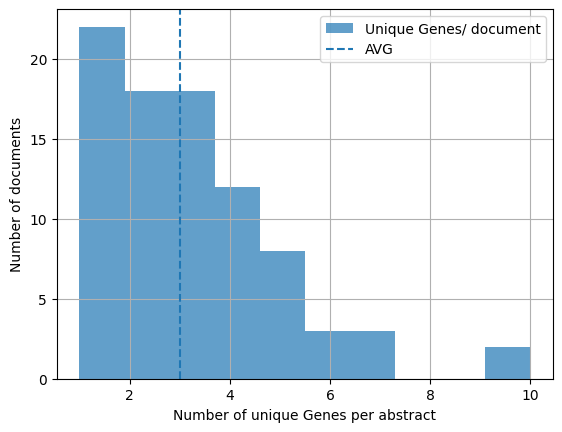

In [41]:
# plot the distribution of number of unique genes / abstract
avg = dat_df.groupby(["pmid"]).nunique().gene_eid.mean()
ax = (dat_df
       .groupby(["pmid"])
       .nunique()
       .gene_eid
       .plot
       .hist(bins=10,logx=False, alpha = 0.7)
);

ax.set_xlabel('Number of unique Genes per abstract')
ax.set_ylabel('Number of documents')
ax.axvline(avg, linestyle='--', color='C0')
ax.legend(["Unique Genes/ document","AVG"])
ax.grid()

fig = ax.get_figure()

In [50]:
from constants import pbt_path
dat_df.to_csv(os.path.join(pbt_path, "pubmed_annotations.tsv"), sep = "\t", header=True, index=False)
